In [1]:
import pandas as pd
import numpy as np
import torch
import os
import sys
from tqdm import tqdm, trange
from bikebench.benchmarking.public_benchmarking_utils import Benchmarker, ScoreReportDashboard

/home/mileva/mambaforge/envs/bike-bench-cuda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device="cpu"

In [3]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Choice, Binary


class BikeBenchProblem(ElementwiseProblem):
    def __init__(self, 
                 bench, 
                 conditioning: dict,
                 **kwargs):

        self.bench = bench

        self.is_objective = np.array(self.bench.is_objective, dtype=bool)

        n_obj = int(self.is_objective.sum().item())
        n_ieq_constr = int((~self.is_objective).sum().item())
        self.conditioning = conditioning


        data = self.bench.data_categorical

        vars = {}
        for col in data.columns:
            series = data[col]
            if pd.api.types.is_bool_dtype(series):
                vars[col] = Binary()
            elif pd.api.types.is_integer_dtype(series):
                low, high    = int(series.min()), int(series.max())
                vars[col]    = Integer(bounds=(low, high))
            elif pd.api.types.is_float_dtype(series):
                low, high    = np.quantile(series, 0.001), np.quantile(series, 0.999)
                vars[col]    = Real(bounds=(float(low), float(high)))
            else:
                opts             = series.dropna().unique().tolist()
                vars[col]        = Choice(options=opts)
        super().__init__(
            vars=vars,
            n_obj=n_obj,
            n_ieq_constr=n_ieq_constr,
            **kwargs                                 
        )

    def _evaluate(self, X, out, *args, **kwargs):
        mixed_row = pd.DataFrame([X], columns=self.vars.keys())

        scores = self.bench.evaluate(mixed_row, conditions = self.conditioning, from_categorical=True)  # ← tensor of shape (1, n_scores)
        f = scores[:,   self.is_objective ].detach().numpy().flatten().tolist()   # ← as list
        g = scores[:, (~self.is_objective) ].detach().numpy().flatten().tolist()

        out["F"] = f
        out["G"] = g


In [ ]:
from pymoo.core.mixed import MixedVariableGA
from pymoo.algorithms.moo.nsga2 import RankAndCrowdingSurvival
from pymoo.core.population import Population
from pymoo.optimize import minimize


def sample_initial_designs_from_dataset(bench, condition, is_objective_bool: np.ndarray, pop_size=100, batch_cap=20000):
    """
    Return a list[dict] of mixed-variable designs to use as initial X in pymoo.minimize.
    - Pulls up to `batch_cap` rows from bench.data_categorical
    - Evaluates feasibility in one batch
    - Keeps rows with all constraints <= 0
    - If not enough feasible rows, fills remainder with random rows (may be infeasible)
    """
    df_all = bench.data_categorical
    n_take = min(batch_cap, len(df_all))
    df = df_all.sample(n=n_take, replace=False, random_state=None)

    with torch.no_grad():
        scores = bench.evaluate(df, conditions=condition, from_categorical=True)  # (N, n_scores) torch.Tensor

    # split objectives/constraints using your mask
    is_obj_t = torch.tensor(is_objective_bool, dtype=torch.bool, device=scores.device)
    cons = scores[:, ~is_obj_t] if (~is_obj_t).any() else None

    if cons is not None and cons.numel() > 0:
        feas = (cons <= 0).all(dim=1).detach().cpu().numpy()
        df_feas = df.iloc[feas.nonzero()[0]]
    else:
        # No constraints → everything is feasible
        df_feas = df

    # choose feasible seeds
    if len(df_feas) >= pop_size:
        chosen = df_feas.sample(n=pop_size, replace=False)
    else:
        # top up with random (possibly infeasible) rows
        need = pop_size - len(df_feas)
        filler = df_all.sample(n=need, replace=(len(df_all) < need))
        chosen = pd.concat([df_feas, filler], axis=0).sample(frac=1.0)

    # convert each row to dict (mixed variable form expected by ElementwiseProblem)
    init_X = [row.to_dict() for _, row in chosen.iterrows()]
    return init_X

def run_nsga2(bench, cond_idx: int, pop_size=100, n_gen=69): #10000 - 3036 //100 -> 69
    condition = bench.get_single_test_condition(cond_idx)
    problem = BikeBenchProblem(bench, condition)

    # Build initial population from dataset (feasible-first)
    init_X = sample_initial_designs_from_dataset(
        bench=bench,
        condition=condition,
        is_objective_bool=problem.is_objective,  # your numpy bool mask
        pop_size=pop_size
    )
    algorithm = MixedVariableGA(pop_size=pop_size, survival=RankAndCrowdingSurvival())

    res = minimize(
        problem,
        algorithm,
        ('n_gen', n_gen),
        sampling=init_X,                   
        seed=1,
        verbose=False,
    )
    mixed_df = pd.DataFrame(list(res.X), columns=problem.vars.keys())
    res_df_onehot = bench.convert_df_to_continuous(mixed_df)
    results_tens = torch.tensor(res_df_onehot.values, dtype=torch.float32)

    #repeat and random sample until we have 100 samples
    N = results_tens.shape[0]
    results_tens = results_tens.repeat((100 // N) + 1, 1)[:100, :]
    return results_tens

bench = Benchmarker(device=device, masked_constraints=False, gradient_free=True)

stacked_results = []
for i in trange(100):
    result = run_nsga2(bench, cond_idx=i)
    stacked_results.append(result.cpu().numpy())
stacked_results = np.vstack(stacked_results)

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluation function called after receiving test conditions; logging as unconditional evaluation!


  0%|          | 0/100 [00:03<?, ?it/s]


TypeError: 'NoneType' object is not iterable

In [ ]:
stacked_results = torch.tensor(stacked_results, dtype=torch.float32)
main_scores_GA, detailed_scores_GA, all_evaluation_scores_GA = bench.score(stacked_results)

bench.save_results("results/benchmark_results/GA")

print(main_scores_GA)

100%|██████████| 100/100 [00:09<00:00, 10.95it/s]

Design Quality ↑ (HV)      0.010177
Constraint Violation ↓          0.0
Sim. to Data ↓ (MMD)       0.621646
Novelty ↑                  34.05647
Binary Validity ↑               1.0
Diversity ↓ (DPP)         11.880045
Evaluation Count          1003600.0
Conditional?                  False
Masked Constraints?           False
Gradient Free?                 True
dtype: object


In [ ]:
bench_masked = Benchmarker(device=device, masked_constraints=True, gradient_free=True)

stacked_results = []
for i in trange(100):
    result = run_nsga2(bench, cond_idx=i)
    stacked_results.append(result.cpu().numpy())
stacked_results = np.vstack(stacked_results)

stacked_results = torch.tensor(stacked_results, dtype=torch.float32)
main_scores_GA_masked, detailed_scores_GA_masked, all_evaluation_scores_GA_masked = bench_masked.score(stacked_results)

bench.save_results("results/benchmark_results/GA_masked")

print(main_scores_GA_masked)

  0%|          | 0/100 [00:23<?, ?it/s]


KeyboardInterrupt: 

/home/mileva/Documents/Lyle/Bike-Bench-Internal/src/bikebench/benchmarking/public_benchmarking_utils.py:384: UserWarning: No model_colors provided; using Matplotlib cycle.
  warnings.warn("No model_colors provided; using Matplotlib cycle.")


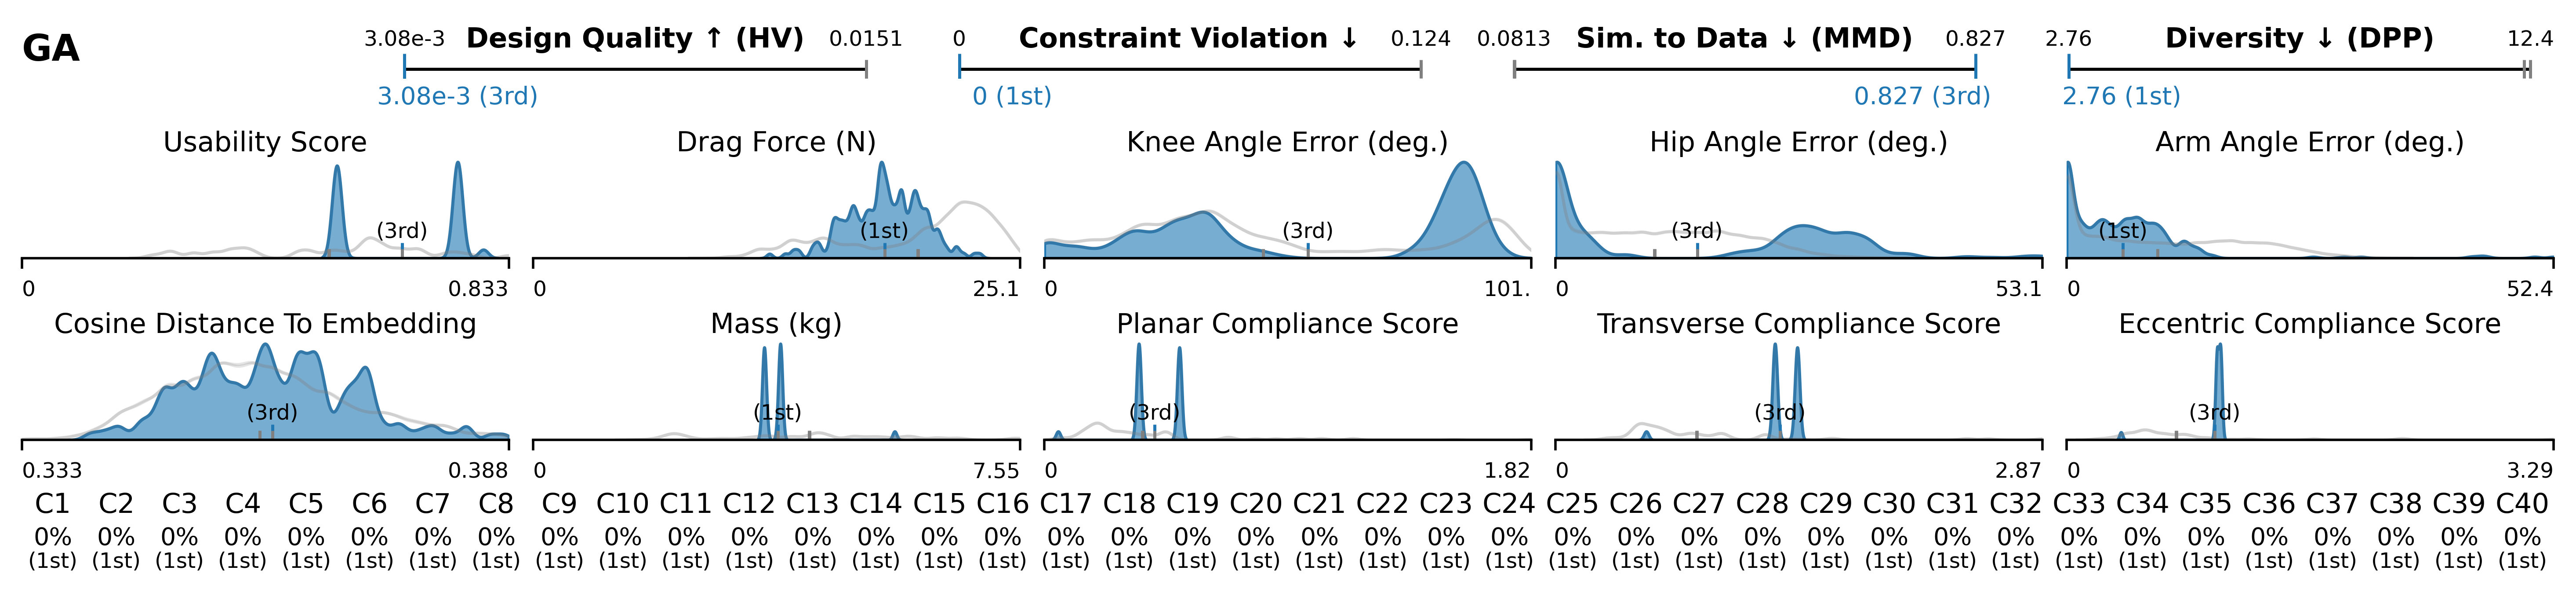

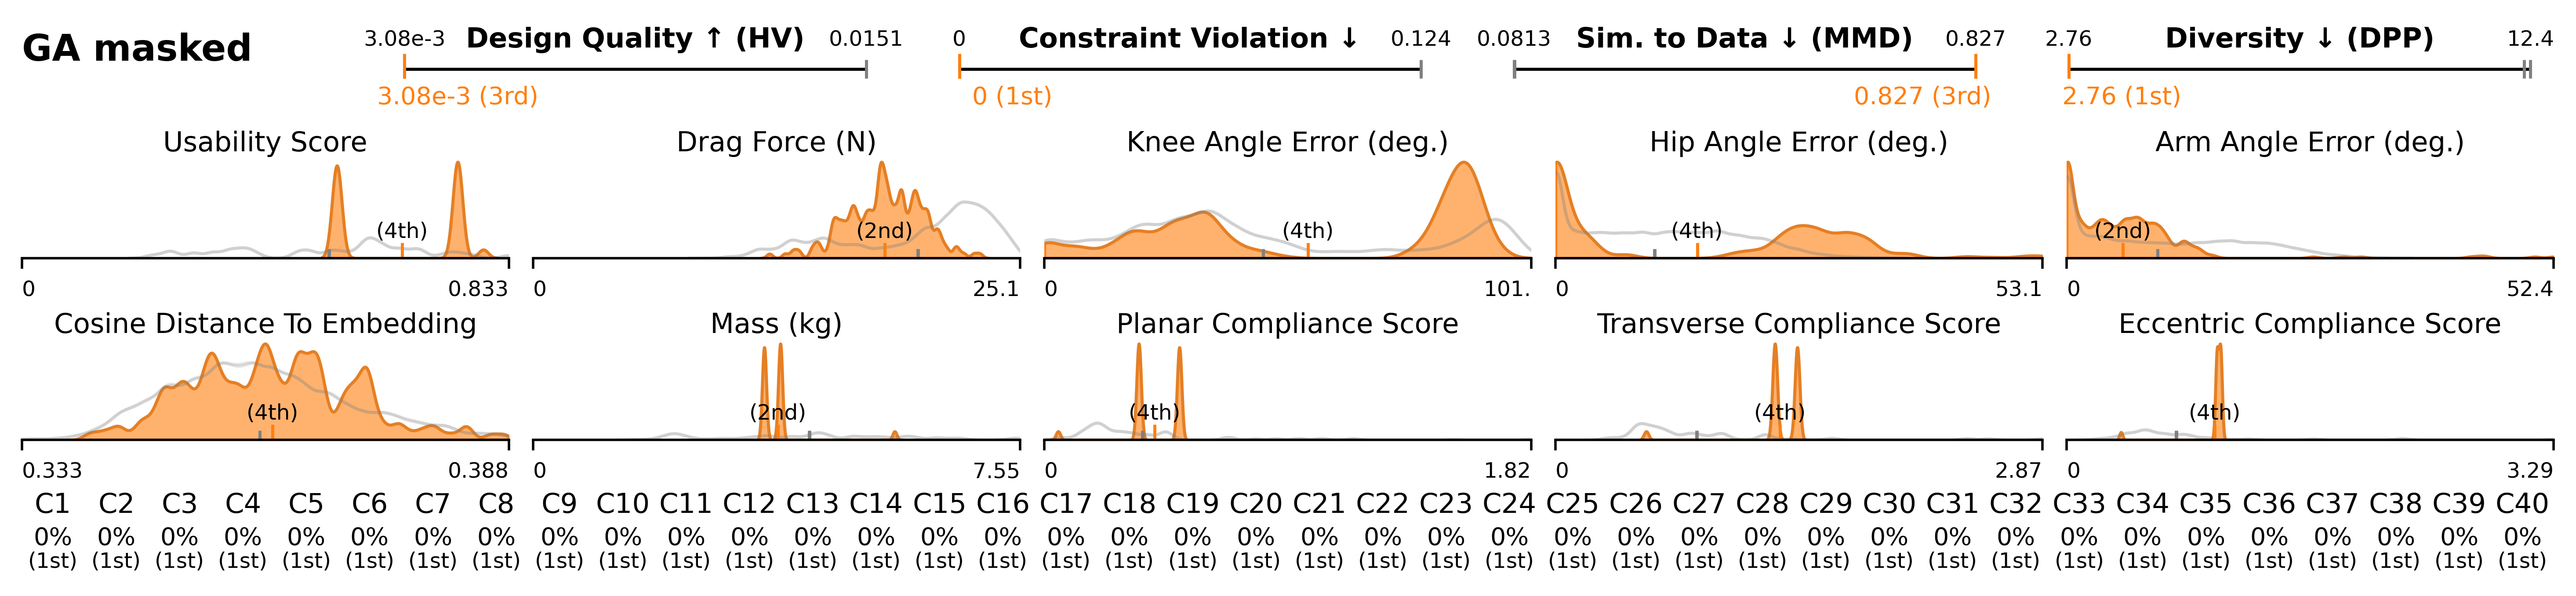

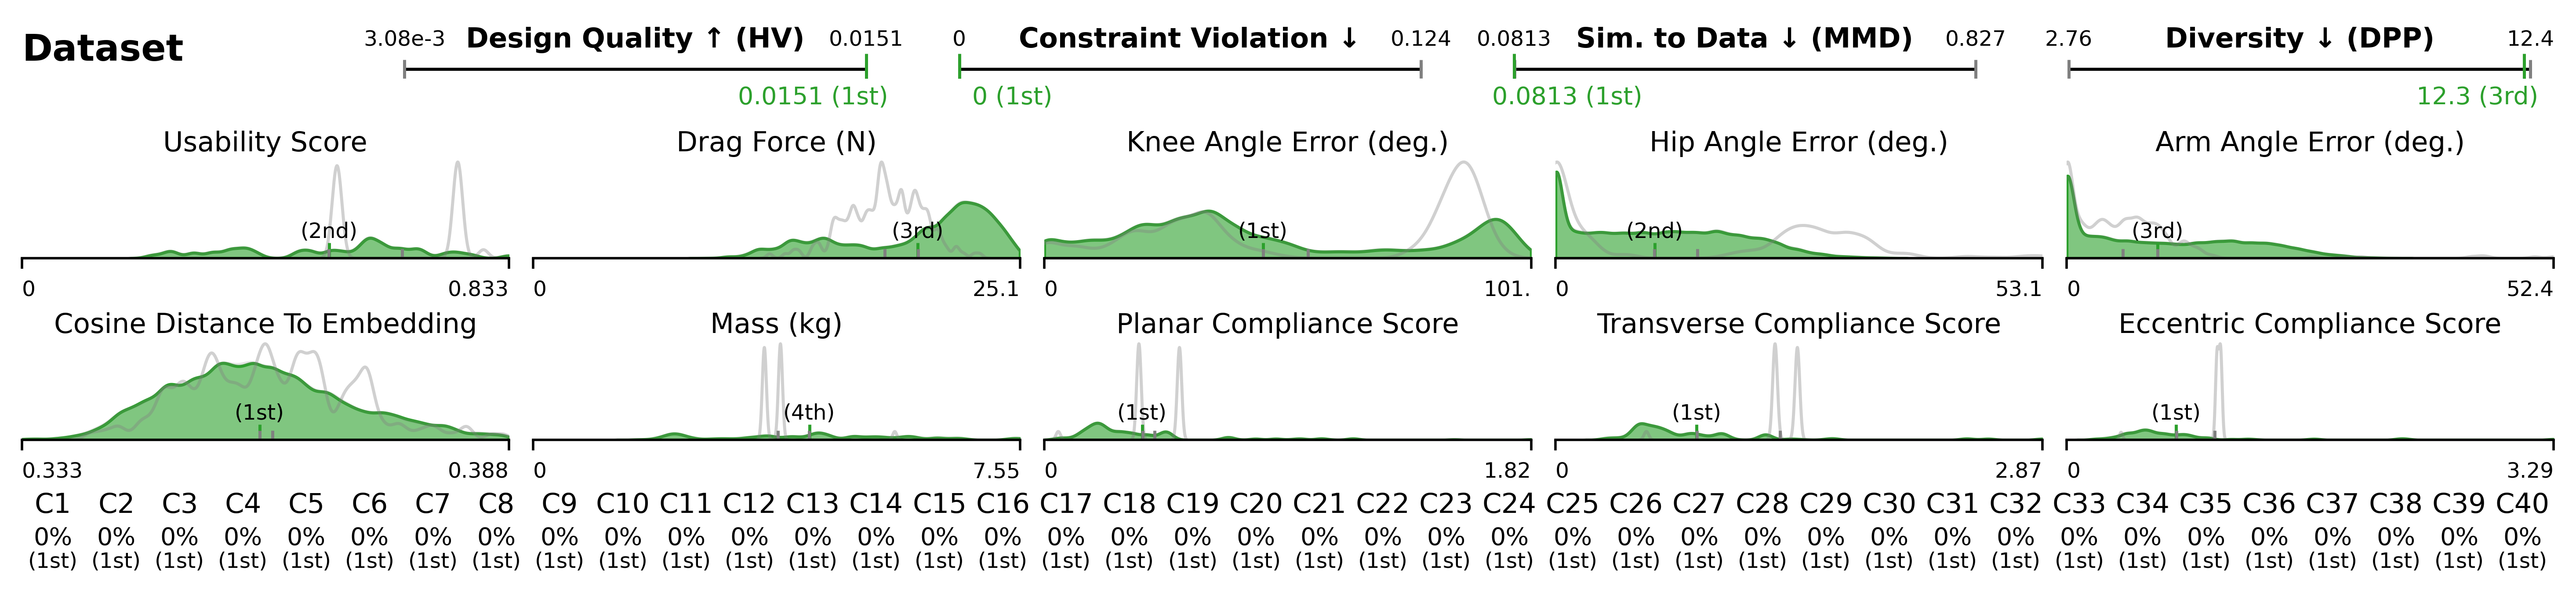

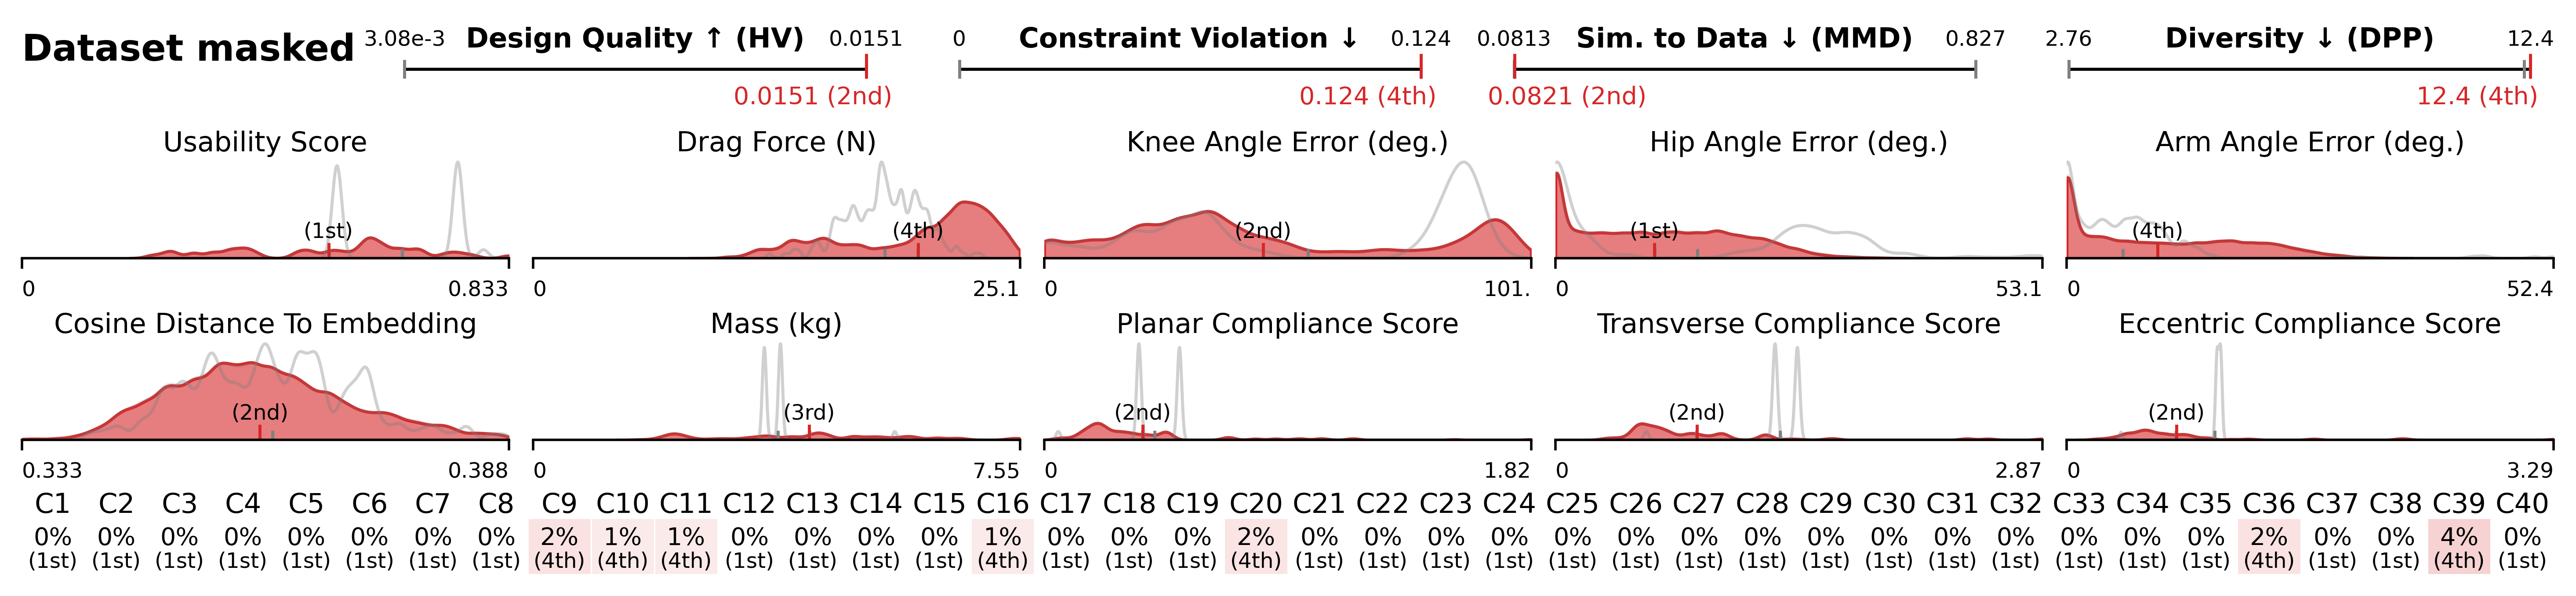

In [ ]:
filepaths_conditional = {
    "GA": "results/benchmark_results/GA",
    "GA masked": "results/benchmark_results/GA_masked",
    "Dataset": "results/benchmark_results/baseline_dataset_conditional",
    "Dataset masked": "results/benchmark_results/baseline_dataset_masked_conditional"
}
dashboard_conditional = ScoreReportDashboard(
    filepaths = filepaths_conditional,
)
for m in filepaths_conditional.keys():
    dashboard_conditional.show_model(m)